# Spatio-Temporal Mapping of Argo Data

This notebook describes how to map Argo data, which is sampling on random points, and map it using Gaussian Process Regression (GPR). This style of mapping was first done for Argo data by Kuusela and Stein 2018[https://doi.org/10.1098/rspa.2018.0400], and this is a python implementation of their paper.

To perform the GPR we use a package called george
[https://george.readthedocs.io/en/latest/].

An introduction to GP regression can be found here: https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb


In this notebook we do the following steps :
    
* Load a subset of Argo data using argopy[https://argopy.readthedocs.io/en/latest/]
* Linearly interpolate onto pressure levels and select one pressure level for use, where we will do the mapping.
* Compute the mean state by least squares fit to a few basis functions, including seasonal harmonics.
* Subtract the mean state from the data to get the anomalies
* The GP is used to map this anomaly field in space and time.



In [2]:
%matplotlib inline
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':14})

In [18]:
ds.to_netcdf('../temp_data.nc')

### Get Argo data in a region using argopy

In [20]:
# Define region of interest to interpolate

ilat = -10
flat = 10
ilon = -130
flon = -110
idepth = 100
fdepth = 300
idate = "2010-01-01"
fdate = "2013-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)

In [5]:
argo_profiles = ds.argo.point2profile() # Convert points to profiles and 
argo_interp = argo_profiles.argo.interp_std_levels([250]) # Interpolate to pressure levels
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]] #select relevant variables

In [6]:
selected_vars

<xarray.Dataset>
Dimensions:            (N_PROF: 5438, PRES_INTERPOLATED: 1)
Coordinates:
    LATITUDE           (N_PROF) float64 9.402 7.482 4.945 ... -5.885 -8.915
    LONGITUDE          (N_PROF) float64 -119.9 -124.2 -125.0 ... -117.2 -125.7
    TIME               (N_PROF) datetime64[ns] 2010-01-01T00:24:57 ... 2012-1...
  * N_PROF             (N_PROF) int64 4201 3477 2564 4347 ... 3869 3291 2845 223
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float64 10.74 10.71 ... 12.04
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           dhruvbalwada
    Fetched_date:         2020/08/14
    Fetched_constraints:  phy_[x=-130.00/-110.00; y=-10.00/10.00; z=100.0/300...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

### Compute the mean based on a few basis functions, using least squares fitting

In [7]:
# Define some functions

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from typing import Iterable


def get_harmonics(nharmonics, time, period=365):
    """Compute the requested number of harmonics
    for a set time.
    
    Parameters
    ----------
    nharmonics : int
        Number of harmonics to compute
    time : int, Iterable
        Time point within period of oscillation.
        This can be either a single int or a 1d-array
    period : int, optional
        Period of oscillation
        
    Returns
    -------
    harmonics: 2d-array
        Array of shape (len(time), nharmonics*2) where
        nharmonics*2 accounts for the cos and sin terms.
    """
    harmonics = np.arange(1, nharmonics + 1)
    if isinstance(time, Iterable):
        time = np.asarray(time)[:, np.newaxis]
        harmonics = harmonics[np.newaxis, :]
    phase = 2 * np.pi * harmonics * time / period
    return np.concatenate([np.cos(phase), np.sin(phase)], axis=-1)


def build_basis(lat, lon, time, nharmonics):
    """Build the 2d local polynomial regression basis
    according to Park2020
    """
    local_polynomlial_reg = np.ones((lat.size, 6 + nharmonics * 2))
    local_polynomlial_reg[:, 1] = lon
    local_polynomlial_reg[:, 2] = lat
    local_polynomlial_reg[:, 3] = lon * lat
    local_polynomlial_reg[:, 4] = lon ** 2
    local_polynomlial_reg[:, 5] = lat ** 2
    local_polynomlial_reg[:, 6:] = get_harmonics(nharmonics, time)
    return local_polynomlial_reg


def find_mean_state(lat, lon, time, data, nharmonics=2):
    """Find the mean state
    
    Parameters
    ----------
    lat, lon, time, data : 1d-array
        Arrays containing latitude, longitude, day of year and
        data.
    nharmonics: int, optional
        Number of harmonics to add into the basis functions
    """
    return lsq_linear(build_basis(lat, lon, time, nharmonics), data)

In [8]:
# Convert time axis to days, so it is same type as lat and lon
Taxis = selected_vars.TIME.values.astype(np.float64)/1e9/24/3600

In [9]:
# Fit the mean

# We solve for the parameters mean state by solving a least squares problem,
# Ax=b , where A is the basis vectors, x are its parameters and b is the mean state+ anomalies
mean_state_fit = find_mean_state(
    selected_vars.LATITUDE,
    selected_vars.LONGITUDE,
    # selected_vars.TIME.dt.dayofyear, # this will not work because it will make the time in each year to be the same
    Taxis,
    selected_vars.TEMP.data.flatten(),
)

# now we predict the mean state 
# (essentially only the part of the data that is mean, 
# discarding the anomalies - which will be modeled by the GP later)
mean_state = np.matmul(build_basis(selected_vars.LATITUDE, selected_vars.LONGITUDE, Taxis, 2), 
                       mean_state_fit.x)


In [10]:
# Get the anomaly
Anomaly = selected_vars.TEMP.squeeze() - mean_state

In [8]:
# Add plot here 
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

#ax.plot(ds.Lon, ds.Lat,  transform=ccrs.PlateCarree())
ax.scatter(Argo_input.Input_coordinates.sel(coordinate='lon'), 
         Argo_input.Input_coordinates.sel(coordinate='lat'), 
         c=Argo_input.Input_coordinates.sel(coordinate='time')/1e9/24/3600/360+1970, 
           s=1,  transform=ccrs.PlateCarree())
#plt.colorbar()
ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
ax.xlim()
#ax.gridlines(draw_labels=True);

Text(0.5, 0, 'Longitude')

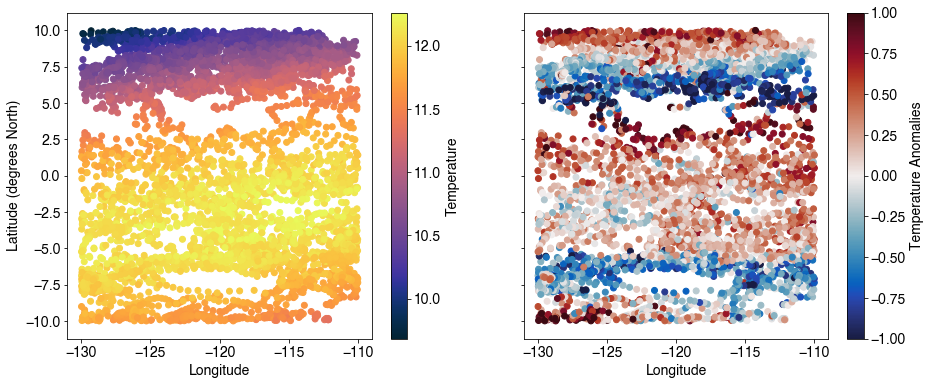

In [11]:
# Plot
# This plot has all the data, not just the data at certain time (so it mixes seasonal changes etc)

import cmocean.cm as cmo

fig, ax = plt.subplots(1,2, figsize=[15,6],sharey=True)
cs1 = ax[0].scatter(selected_vars.LONGITUDE,selected_vars.LATITUDE,c=mean_state, cmap=cmo.thermal)

cbar=plt.colorbar(cs1,ax=ax[0])
cbar.set_label('Temperature')


cs2 = ax[1].scatter( selected_vars.LONGITUDE,selected_vars.LATITUDE,c=Anomaly, cmap=cmo.balance, vmin=-1, vmax=1)
cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')

ax[0].set_ylabel('Latitude (degrees North)')

ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('Longitude')

        

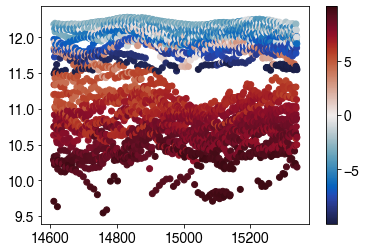

In [39]:
plt.scatter(Taxis, mean_state, c=selected_vars.LATITUDE, cmap=cmo.balance)
plt.colorbar()

plt.xlabel('days')
plt.ylabel('Mean temp')

# Check if the mean has some seasonal cycle

In [58]:
# Also make some predictions on a regular grid (for ease of plotting)

lat = np.linspace(ilat, flat, 60) # can change that 50 if you want predictions at finer scales
lon = np.linspace(ilon, flon, 50)

llon, llat = np.meshgrid(lon, lat)

# we need reshape the above into single column vectors, because that is expected. 
llons = llon.reshape(-1)
llats = llat.reshape(-1)

mean_state_s = np.matmul(build_basis(llats, llons, (2011-1970)*365, 2), mean_state_fit.x)
# chose a particular time to get a prediction at a certain time
# all the above thing does is Ax, which gives us b - the mean state. 
# you could also use the above matrix multiply to generate a time series at a location. 


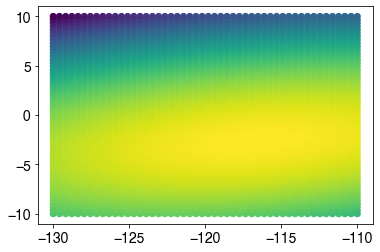

In [59]:
plt.scatter(llons, llats, c= mean_state_s.T)

In [63]:
# Could also regrid 
# we can regrid and create this 2D array 
# we know the size is 50X50, because that is what we chose above.
mean_state_g = mean_state_s.reshape(60,50)

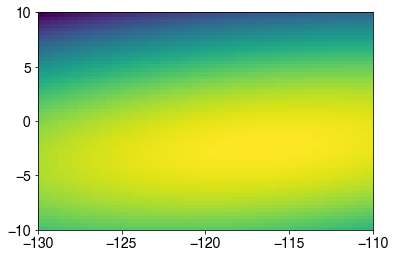

In [65]:
plt.pcolormesh(llon, llat, mean_state_g)

In [70]:
xmean_state = xr.DataArray(mean_state_g, dims= ["lat","lon"],coords=[ lat,lon])

In [71]:
xmean_state

<xarray.DataArray (lat: 60, lon: 50)>
array([[11.4394775 , 11.45129268, 11.46248021, ..., 11.31631079,
        11.29862684, 11.28031525],
       [11.48957094, 11.50176575, 11.51333292, ..., 11.38424727,
        11.36694296, 11.34901101],
       [11.53676961, 11.54934407, 11.56129088, ..., 11.449289  ,
        11.43236433, 11.41481202],
       ...,
       [ 9.67477517,  9.70822979,  9.74105676, ..., 10.5686623 ,
        10.5726178 , 10.57594565],
       [ 9.5598676 ,  9.59370186,  9.62690848, ..., 10.47159779,
        10.47593292, 10.47964041],
       [ 9.44206528,  9.47627918,  9.50986543, ..., 10.37163851,
        10.37635329, 10.38044042]])
Coordinates:
  * lat      (lat) float64 -10.0 -9.661 -9.322 -8.983 ... 8.983 9.322 9.661 10.0
  * lon      (lon) float64 -130.0 -129.6 -129.2 -128.8 ... -110.8 -110.4 -110.0

In [75]:
# Now we have the anomaly data that the GP will be computed on
selected_vars.LATITUDE

<xarray.DataArray 'LATITUDE' (N_PROF: 3515)>
array([ 9.40200043,  7.48199987,  4.945     , ...,  7.804     ,
       -9.77534   ,  9.257     ])
Coordinates:
    LATITUDE   (N_PROF) float64 9.402 7.482 4.945 2.113 ... 7.804 -9.775 9.257
    LONGITUDE  (N_PROF) float64 -119.9 -124.2 -125.0 ... -123.1 -126.7 -122.8
    TIME       (N_PROF) datetime64[ns] 2010-01-01T00:24:57 ... 2011-12-31T11:...
  * N_PROF     (N_PROF) int64 2854 2349 1786 2985 524 ... 2511 2613 3523 2265

In [80]:
Taxisxr = xr.DataArray(Taxis, coords=selected_vars.LATITUDE.coords).rename('Time')

In [105]:
import pandas as pd
Taxisxr = xr.DataArray(Taxis, coords=selected_vars.LATITUDE.coords).rename('Time')
# The lon,lat,time coordinates need to be in a specific format for george

Input_coordinates=(xr.concat((selected_vars.LONGITUDE,selected_vars.LATITUDE, Taxisxr), dim='coordinate').T)
#                                     name="coordinate").T

In [106]:
Input_coordinates

<xarray.DataArray 'LONGITUDE' (N_PROF: 3515, coordinate: 3)>
array([[-1.19885002e+02,  9.40200043e+00,  1.46100173e+04],
       [-1.24168999e+02,  7.48199987e+00,  1.46103755e+04],
       [-1.25006000e+02,  4.94500000e+00,  1.46106357e+04],
       ...,
       [-1.23096000e+02,  7.80400000e+00,  1.53392923e+04],
       [-1.26685480e+02, -9.77534000e+00,  1.53393844e+04],
       [-1.22828000e+02,  9.25700000e+00,  1.53394834e+04]])
Coordinates:
    TIME       (N_PROF) datetime64[ns] 2010-01-01T00:24:57 ... 2011-12-31T11:...
    LONGITUDE  (N_PROF) float64 -119.9 -124.2 -125.0 ... -123.1 -126.7 -122.8
    LATITUDE   (N_PROF) float64 9.402 7.482 4.945 2.113 ... 7.804 -9.775 9.257
  * N_PROF     (N_PROF) int64 2854 2349 1786 2985 524 ... 2511 2613 3523 2265
Dimensions without coordinates: coordinate

In [89]:
import george as grg

Choose a kernel (covariance) function to model these data, assume a zero mean model

In [91]:
# Define scaling for lat-lon to distance
Lxscale = 110e3*np.cos(np.pi/180*0)
Lyscale = 110e3

# Define kernel (covariance function)
# A simple exponential squared kernel is used, assuming isentropy. 
# There are a number of kernels that can be used

kernel_argo = np.var(Anomaly).values*grg.kernels.ExpSquaredKernel([100e3**2/Lxscale**2, 
                                                100e3**2/Lyscale**2, 
                                                30**2
                                               ], ndim=3)

In [92]:
# Now let us set up the GP. 

gp_argo = grg.GP(kernel_argo)

In [107]:
gp_argo.compute(Input_coordinates, 0.01) # 0.01 is an estimated observational error/ noise

In [108]:
# Define some test grid points

test_pts_argo = np.array(np.meshgrid(np.linspace(-130,-116,30), 
                       np.linspace(-10,10,30),
                         (2011-1970)*365)).reshape(3,-1).T
test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [109]:
pred_argo, pred_var_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo = xr.DataArray(pred_argo,  dims={"test_pt_num"})
pred_var_argo = xr.DataArray(pred_var_argo,  dims={"test_pt_num"})

In [114]:
x_sel

<xarray.DataArray 'LONGITUDE' (N_PROF: 3515, coordinate: 3)>
array([[-1.19885002e+02,  9.40200043e+00,  1.46100173e+04],
       [-1.24168999e+02,  7.48199987e+00,  1.46103755e+04],
       [-1.25006000e+02,  4.94500000e+00,  1.46106357e+04],
       ...,
       [-1.23096000e+02,  7.80400000e+00,  1.53392923e+04],
       [-1.26685480e+02, -9.77534000e+00,  1.53393844e+04],
       [-1.22828000e+02,  9.25700000e+00,  1.53394834e+04]])
Coordinates:
    TIME       (N_PROF) datetime64[ns] 2010-01-01T00:24:57 ... 2011-12-31T11:...
    LONGITUDE  (N_PROF) float64 -119.9 -124.2 -125.0 ... -123.1 -126.7 -122.8
    LATITUDE   (N_PROF) float64 9.402 7.482 4.945 2.113 ... 7.804 -9.775 9.257
  * N_PROF     (N_PROF) int64 2854 2349 1786 2985 524 ... 2511 2613 3523 2265
Dimensions without coordinates: coordinate

KeyError: 'coordinate'

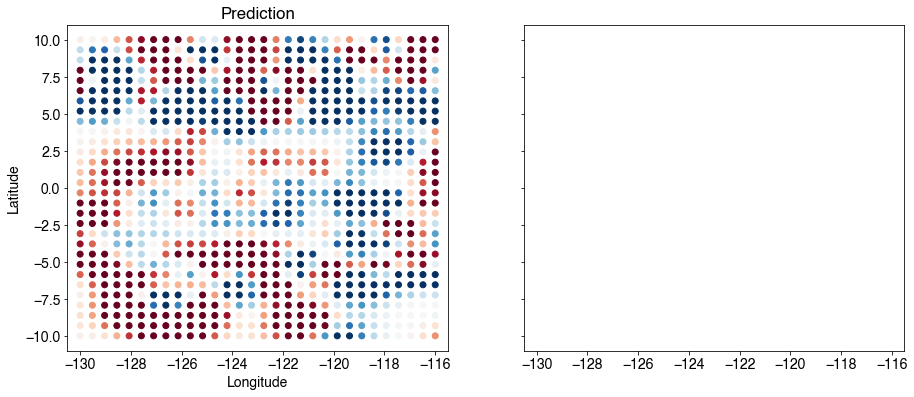

In [113]:
fig,ax=plt.subplots(1,2,figsize=(15,6),sharex=True,sharey=True)

cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
#plt.colorbar(cs,ax=ax[0])
ax[0].set_title('Prediction')

ax[0].set_xlim(-130.5,-115.5)

x_sel = Input_coordinates
y_sel = Anomaly

cs2=ax[1].scatter(x_sel.sel(coordinate='LONGITUDE'), x_sel.sel(coordinate='LATITUDE'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[1].set_xlabel('Longitude')

cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')
ax[1].set_title('Truth')

plt.tight_layout()

In [85]:
# Compute the Maximum Likelihood

print("Initial ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))

Initial ln-likelihood: -1354.24


Use Scipys optimize function to fit the maximun likelihood parameters 

In [86]:
from scipy.optimize import minimize


def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Anomaly)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Anomaly)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [87]:
%time result_argo = minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo)

CPU times: user 2.08 s, sys: 39.7 ms, total: 2.12 s
Wall time: 533 ms


In [88]:
# Optimized likelihood

gp_argo.set_parameter_vector(result_argo.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))



Final ln-likelihood: -216.26


In [89]:
# Here the new prediction is made using the MLE parameter estimates

pred_MLE_argo, pred_var_MLE_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo = xr.DataArray(pred_MLE_argo,  dims={"test_pt_num"})
pred_var_MLE_argo = xr.DataArray(pred_var_MLE_argo,  dims={"test_pt_num"})

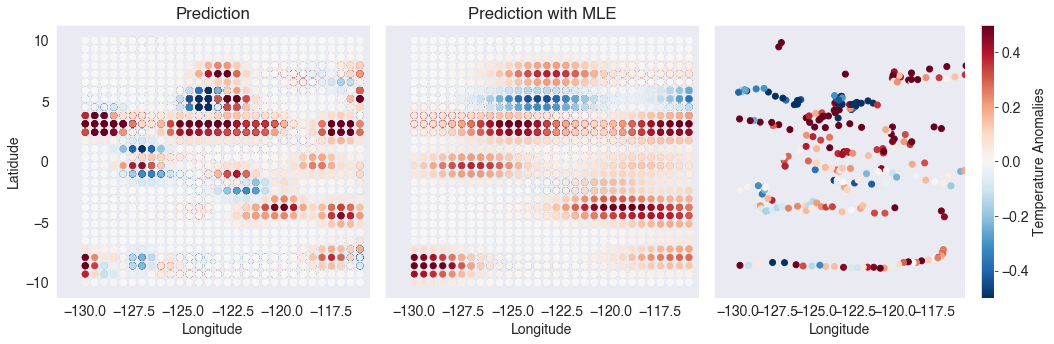

In [90]:
fig,ax= plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latidude')
ax[0].set_title('Prediction')

cs2=ax[1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[1].set_xlabel('Longitude')
ax[1].set_title('Prediction with MLE')


#x_sel = Input_coordinates.where(np.logical_and(Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
#                               Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
#                                drop='true')

#y_sel = Anomaly.where(np.logical_and(Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
#                               Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
#                                drop='true')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, cmap='RdBu_r')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')

x_sel = Input_coordinates
y_sel = Anomaly

cs=ax[2].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')

ax[2].set_xlabel('Longitude')
cbar=plt.colorbar(cs,ax=ax[2])
cbar.set_label('Temperature Anomalies')
ax[2].set_label('Truth')
ax[2].set_xlim(-131.5, -115.5)

plt.tight_layout()



In [91]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 8.31290485e-02 3.11606183e+00
 4.17266220e-01 1.00556243e+02]


In [92]:
print('Lx(km)='+str((np.exp(gp_argo.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo.parameter_vector[5]))**0.5))

# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Lx(km)=243.4050054140724
Ly(km)=116.27306451901603
Timescale(km)=10.027773585663025


In [ ]:
# What about a time series prediction.

test_pts_argo2 = np.array(np.meshgrid(np.linspace(-144,-136,30), 
                       -50,
                       np.linspace((2013-1970)*365, (2019-1970)*365, 120)
                                     )).reshape(3,-1).T

In [ ]:
test_pts_argo2 = xr.DataArray(test_pts_argo2,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo2.shape[0]), ['lon','lat','time']] ) 

In [ ]:
pred_MLE_argo2, pred_var_MLE_argo2 = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo2, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo2 = xr.DataArray(pred_MLE_argo2,  dims={"test_pt_num"})
pred_var_MLE_argo2 = xr.DataArray(pred_var_MLE_argo2,  dims={"test_pt_num"})

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)

plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
plt.title('Prediction based on MLE')

plt.subplot(122)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')
plt.scatter(x_sel.sel(coordinate='lon'), 
            x_sel.sel(coordinate='time')/365 + 1970, 
            c=y_sel, vmin=-.5, vmax=.5, s=10, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
# A bit hard to see, but some sign of eastward propogation is visible.
# Also since the data ends in 2018, the prediction after that is just 0.

In [ ]:
x_sel = test_pts_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_sel = pred_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_var = pred_var_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')

plt.fill_between(x_sel.sel(coordinate='time')/365 + 1970, 
                 y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="b", alpha=0.2)
plt.plot(x_sel.sel(coordinate='time')/365 + 1970, y_sel)
#plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
#            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
#            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.ylabel('Data')
plt.xlabel('time')

plt.title('Prediction based on MLE')

# The prediction of the time series is relatively poor,
# but considering the limited amount of data it is probably not bad.

In [36]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 8.31290486e-02 4.17266215e-01
 3.11606189e+00 1.00556243e+02]


Lx(km)=54.43187104344395
Ly(km)=194.17607705144124
Timescale(km)=10.027773566026227
